In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *
from pprint import pprint
from IPython.core.display import display, HTML

In [2]:
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/3Alpha1200Beta3000Dist"

In [3]:
keys = ["reqs", "dist", "drt", "dcut", "l"]
values = [None, "3000", "100", None, None]
key_val_map = dict(zip(keys, values))

def readData(load_path):
#     uni_dirs = getUniDirs(load_path, 100)

    saved_path = os.path.join(load_path, "saved.pkl")
    saved_path_car = os.path.join(load_path, "saved_car.pkl")
    # Load car dataframe
    if os.path.isfile(saved_path_car):
        df_car = pd.read_pickle(saved_path_car)
    else:
#         car_dir = getCarDir(load_path)
#         df_car = getTrips(car_dir, "car")
#         df_car.to_pickle(saved_path_car)
        df_car = -1
    
    # Load bimodal dataframe
    if os.path.isfile(saved_path):
        df = pd.read_pickle(saved_path)
    else:
#         dcut_dirs = getBimDirsVaryDCut(load_path, 1000)
        dcut_dirs = getDirs(load_path, keys, values)
        cols = ["reqs", "dcut", "l", "occupancy", "detour", "servability", "req_mean_dist", "drt_travel_time_normalized",
                "drt_wait_time_normalized", "drt_distance", "cummulative_dist_drt",
                "cummulative_dist_drt_unshared", "pkm_drt"]
        df = pd.DataFrame(np.full((len(dcut_dirs),len(cols)), np.nan), columns=cols)
        for i,e in enumerate(dcut_dirs):
            row = df.iloc[i,:]
            try:
                row.loc["reqs"] = float(e[keys.index("reqs")])
                row.loc["dcut"] = float(e[keys.index("dcut")])
                row.loc["l"] = float(e[keys.index("l")])
                dic = e[-1]
                row.loc["occupancy"], _ = getDrtOccupandyAndStandingFrac(dic, False, False)
                df_detour = getDrtDetours(dic)
                row.loc["detour"] = df_detour["distanceDetour"].mean()
                trip_succ = getTripSuccess(dic)
                row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
                df_persons = getPersons(dic)
                row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
                drt_trips, drt_trips_perperson = getDrtTrips(dic)
                row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
                row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
                df_detour = df_detour.set_index("person")
                row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
                row.loc["drt_travel_time_normalized"] = (drt_trips_perperson["travelTime"]/df_detour["unsharedTime"]).mean()
                row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
                _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
            except KeyError:
                print("KeyError")
                pass

            print("-----")

        df.to_pickle(saved_path)

    
    df = df.sort_values(["reqs", "dcut", "l"])
#     display(df["l"])
#     display(df["dcut"])
    df["l"] /= df["req_mean_dist"].mean()
    df["dcut"] /= df["req_mean_dist"].mean()
#     data = np.einsum("ijk->jik", data)
    
    return df, df_car

In [7]:
display(df)

,reqs,dcut,l,occupancy,detour,servability,req_mean_dist,drt_travel_time_normalized,drt_wait_time_normalized,drt_distance,cummulative_dist_drt,cummulative_dist_drt_unshared,pkm_drt,efficiency,quality
2131,5000.0,0.102947,0.102947,0.259808,1.072756,1.000000,1952.680215,2.099540,8.683680,310.351611,5596283.62,1354669.86,1456.0,0.659609,5.835278
2141,5000.0,0.102947,0.205894,0.355224,1.154629,1.000000,1952.680215,2.551465,8.013737,533.740056,7431589.53,2269128.54,2663.0,0.893003,3.152422
2132,5000.0,0.102947,0.308841,0.463065,1.253553,1.000000,1952.680215,2.816728,6.566768,775.817353,8189561.67,3026994.74,3874.0,1.081044,1.997626
2148,5000.0,0.102947,0.411788,0.583100,1.333810,1.000000,1952.680215,3.037789,5.417926,1033.744890,8637722.06,3794114.53,5167.0,1.217161,1.408994
2143,5000.0,0.102947,0.514735,0.755141,1.455826,1.000000,1952.680215,3.320938,4.424891,1373.315888,8900858.50,4623191.01,6867.0,1.362810,0.971710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,17500.0,2.573674,2.161886,2.004882,1.695459,0.683086,1936.504729,1.716242,4.112734,4489.182930,26260690.79,30628289.09,53664.0,1.954111,0.255248
930,17500.0,2.573674,2.264833,2.008886,1.690773,0.684857,1936.504729,1.711797,4.116437,4475.461577,26240448.36,30681848.81,53643.0,1.938881,0.256740
928,17500.0,2.573674,2.367780,2.017792,1.688853,0.691029,1936.504729,1.710558,4.129781,4457.628617,26232902.28,30837113.85,53906.0,1.920449,0.258060
944,17500.0,2.573674,2.470727,1.991380,1.687869,0.681371,1936.504729,1.708623,4.106394,4469.817041,26287084.18,30614632.81,53303.0,1.950104,0.257506


---
# Visualization

In [22]:
# dcuts, ells, data = readData(10000)
df, df_car = readData(path)
df["efficiency"] = df["drt_distance"]/df["req_mean_dist"]*df["detour"]/df["occupancy"]
df["quality"] = 1/(df["occupancy"]*df["efficiency"])
# df["quality"] = 1/(df["drt_distance"]/df["req_mean_dist"].mean()*df["detour"])

df_reqs = df[df["reqs"]==17500]
print(str(df_reqs["req_mean_dist"].mean()) + " should be a lot larger than " + str(df_reqs["req_mean_dist"].std()))

data = df_reqs.pivot(index="l", columns="dcut", values=["efficiency", "servability", "drt_travel_time_normalized",
                                                       "drt_wait_time_normalized" ,"drt_distance",
                                                       "req_mean_dist", "cummulative_dist_drt",
                                                      "cummulative_dist_drt_unshared", "pkm_drt",
                                                       "occupancy", "detour", "quality"])

X, Y = np.meshgrid(data["efficiency"].index.to_numpy(), data["efficiency"].columns.to_numpy(), indexing='ij')

1936.5047292302622 should be a lot larger than 2.275557929537614e-13


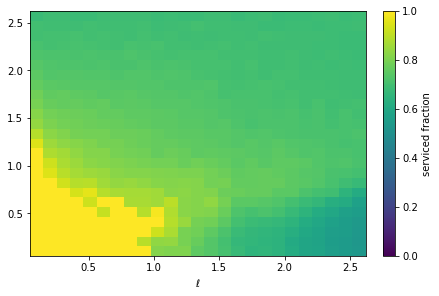

In [23]:
fig, ax = plt.subplots(constrained_layout=True)

im = ax.pcolor(X,Y,data["servability"].to_numpy(), shading='auto', vmin=0)#, vmax=1, linewidth=0)
# im.set_edgecolor('face')
# ax = sns.heatmap(data[:,:,0])
plt.colorbar(im, label="serviced fraction", )
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(r"$\ell$")
# ax.set_ylabel(r"$d_\mathrm{cut}$")
# ax.set_ylabel("Bimodal Fraction")

# fig.savefig("figures/ServabilityConstDrtDemand3Alpha900Beta.png", dpi=200)
plt.show()

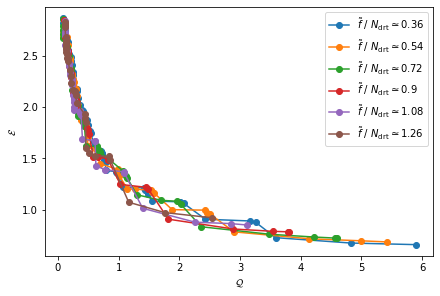

In [24]:
fig, ax = plt.subplots(constrained_layout=True)

paretos = []

for reqs in df["reqs"].unique():
    df_reqs = df[df["reqs"]==reqs]
    data = df_reqs.pivot(index="l", columns="dcut", values=["efficiency", "quality"])
    
    efficiencies = data["efficiency"].to_numpy().flatten()
    qualities = data["quality"].to_numpy().flatten()
    costs = np.stack((-efficiencies, -qualities), axis=1)

    pareto_efficient = isParetoEfficient(costs)
    pareto_efficiencies = efficiencies[pareto_efficient]
    pareto_qualities = qualities[pareto_efficient]
    sorted_idx = np.argsort(pareto_qualities)
    pareto = np.stack((pareto_qualities[sorted_idx], pareto_efficiencies[sorted_idx]), axis=1)
    paretos.append(pareto)
    reqs_per_mean_dist_time = reqs/(9*3600)*df_reqs["req_mean_dist"].mean()/(30/3.6)
    order_param = reqs_per_mean_dist_time/100
    ax.plot(pareto[:,0], pareto[:,1], "-o", label=r"$\tilde{f}\ /\ N_\mathrm{drt} \simeq $"+f"{round(order_param,2)}")

# ax.plot(qualities[~pareto_efficient], efficiencies[~pareto_efficient], "o", label="data")
# ax.plot(pareto_qualities[sorted_idx], pareto_efficiencies[sorted_idx], "-o", c="green", ms=4, label="pareto front")
ax.set_xlabel(r"$\mathcal{Q}$")
ax.set_ylabel(r"$\mathcal{E}$")
ax.legend()

# fig.savefig("figures/DrtPartParetoFronts.jpg", dpi=300)
plt.show()

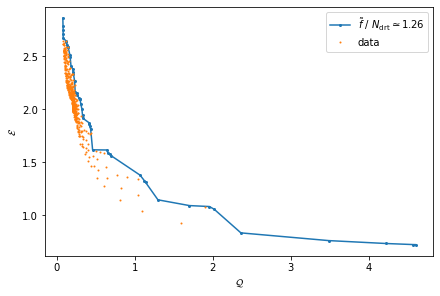

In [20]:
fig, ax = plt.subplots(constrained_layout=True)

paretos = []

df_reqs = df[df["reqs"]==10000]
data = df_reqs.pivot(index="l", columns="dcut", values=["efficiency", "quality"])

efficiencies = data["efficiency"].to_numpy().flatten()
qualities = data["quality"].to_numpy().flatten()
costs = np.stack((-efficiencies, -qualities), axis=1)

pareto_efficient = isParetoEfficient(costs)
pareto_efficiencies = efficiencies[pareto_efficient]
pareto_qualities = qualities[pareto_efficient]
sorted_idx = np.argsort(pareto_qualities)
pareto = np.stack((pareto_qualities[sorted_idx], pareto_efficiencies[sorted_idx]), axis=1)
reqs_per_mean_dist_time = reqs/(9*3600)*df_reqs["req_mean_dist"].mean()/(30/3.6)
order_param = reqs_per_mean_dist_time/100
ax.plot(pareto[:,0], pareto[:,1], "-o", label=r"$\tilde{f}\ /\ N_\mathrm{drt} \simeq $"+f"{round(order_param,2)}", ms=2)

ax.plot(qualities[~pareto_efficient], efficiencies[~pareto_efficient], "o", label="data", ms=1)
# ax.plot(pareto_qualities[sorted_idx], pareto_efficiencies[sorted_idx], "-o", c="green", ms=4, label="pareto front")
ax.set_xlabel(r"$\mathcal{Q}$")
ax.set_ylabel(r"$\mathcal{E}$")
ax.legend()

# fig.savefig("figures/DrtPartParetoFronts.jpg", dpi=300)
plt.show()

---

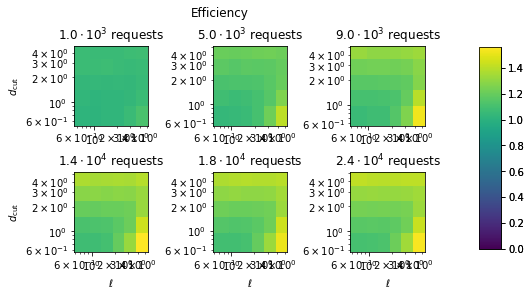

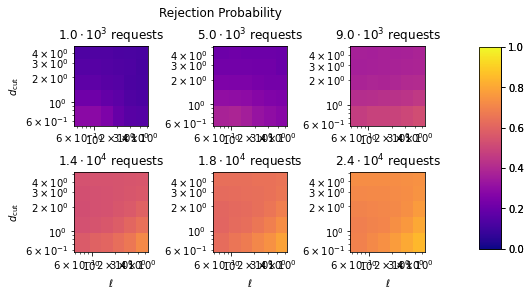

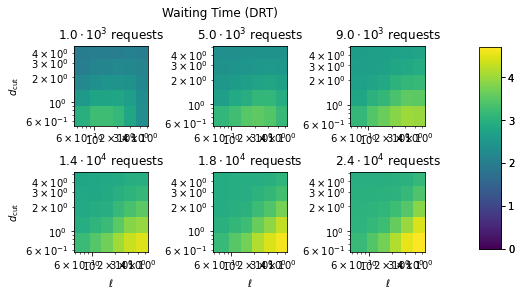

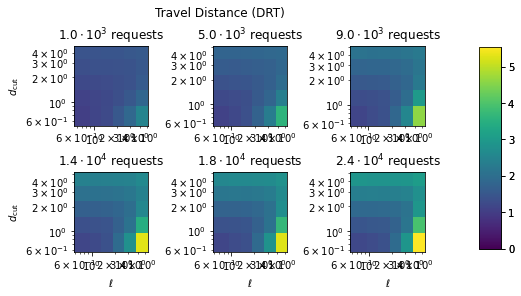

In [18]:
fig1, axes1 = plt.subplots(2,3, constrained_layout=True)
fig2, axes2 = plt.subplots(2,3, constrained_layout=True)
fig3, axes3 = plt.subplots(2,3, constrained_layout=True)
fig4, axes4 = plt.subplots(2,3, constrained_layout=True)
fig_list = [fig1, fig2, fig3, fig4]
fig_titles = ["Efficiency", "Rejection Probability", "Waiting Time (DRT)", "Travel Distance (DRT)"]
save_names = ["Efficiency", "Rejection", "WaitingTimeDrt", "TravelDistanceDrt"]
axes_list = [axes1, axes2, axes3, axes4]
reqs = np.array([1000,5000,9000,14000,18000,24000])
reqs_log = np.log10(reqs).astype(np.int64)
coeffs = np.round(reqs/10**reqs_log,1)
efficiencies = []
servabilities = []
drt_wait_times = []
drt_distances = []
efficiency_max = 0
drt_wait_time_max = 0
drt_distance_max = 0

for i,r in enumerate(reqs):
    df, df_car = readData(r)
    df = df[df["l"] < 5]
    df = df[df["dcut"] < 5]
    data = df.pivot(index="l", columns="dcut", values=["efficiency", "servability", "drt_wait_time",
                                                       "drt_wait_time_normalized", "drt_distance",
                                                       "req_mean_dist", "cummulative_dist_drt",
                                                      "cummulative_dist_drt_unshared"])
#     efficiencies.append(data["efficiency"])
    efficiencies.append(data["cummulative_dist_drt"]/data["cummulative_dist_drt_unshared"])
    servabilities.append(1 - data["servability"])
    drt_wait_times.append(data["drt_wait_time_normalized"])
    drt_distances.append(data["drt_distance"]/data["req_mean_dist"])
    efficiency_max = np.maximum(efficiency_max, efficiencies[i].to_numpy().max())
    drt_wait_time_max = np.maximum(drt_wait_time_max, drt_wait_times[i].to_numpy().max())
    drt_distance_max = np.maximum(efficiency_max, drt_distances[i].to_numpy().max())
    
ims = []
for i in range(len(reqs)):
    X,Y = np.meshgrid(efficiencies[i].index.to_numpy(), efficiencies[i].columns.to_numpy(), indexing='ij')
    im1 = axes1[i//3,i%3].pcolor(X,Y,efficiencies[i].to_numpy(), shading='auto', vmin=0, vmax=efficiency_max)#, linewidth=0)
    im2 = axes2[i//3,i%3].pcolor(X,Y,servabilities[i].to_numpy(), shading='auto', cmap="plasma", vmin=0, vmax=1)#, linewidth=0)
    im3 = axes3[i//3,i%3].pcolor(X,Y,drt_wait_times[i].to_numpy(), shading='auto', vmin=0, vmax=drt_wait_time_max)#, linewidth=0)
    im4 = axes4[i//3,i%3].pcolor(X,Y,drt_distances[i].to_numpy(), shading='auto', vmin=0, vmax=drt_distance_max)#, linewidth=0)
    ims =[im1, im2, im3, im4]
    for im in ims:
        im.set_edgecolor('face')
    
    for axes in axes_list:
        axes[i//3,i%3].set_xscale("log")
        axes[i//3,i%3].set_yscale("log")

for i,axes in enumerate(axes_list):
    axes[1,0].set_xlabel(r"$\ell$")
    axes[1,1].set_xlabel(r"$\ell$")
    axes[1,2].set_xlabel(r"$\ell$")
    axes[1,0].set_ylabel(r"$d_\mathrm{cut}$")
    axes[0,0].set_ylabel(r"$d_\mathrm{cut}$")
#     axes[0,0].set_title(rf"{reqs[0]:.1E}$a =b$ requests")
#     axes[0,1].set_title(rf"{reqs[1]:.1E} requests")
#     axes[0,2].set_title(rf"{reqs[2]:.1E} requests")
#     axes[1,0].set_title(rf"{reqs[3]:.1E} requests")
#     axes[1,1].set_title(rf"{reqs[4]:.1E} requests")
#     axes[1,2].set_title(rf"{reqs[5]:.1E} requests")
    axes[0,0].set_title(rf"${coeffs[0]}\cdot 10^{reqs_log[0]}$ requests")
    axes[0,1].set_title(rf"${coeffs[1]}\cdot 10^{reqs_log[1]}$ requests")
    axes[0,2].set_title(rf"${coeffs[2]}\cdot 10^{reqs_log[2]}$ requests")
    axes[1,0].set_title(rf"${coeffs[3]}\cdot 10^{reqs_log[3]}$ requests")
    axes[1,1].set_title(rf"${coeffs[4]}\cdot 10^{reqs_log[4]}$ requests")
    axes[1,2].set_title(rf"${coeffs[5]}\cdot 10^{reqs_log[5]}$ requests")
for i,fig in enumerate(fig_list):
    cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(ims[i], cax=cbar_ax)
for i,fig in enumerate(fig_list):
    cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(ims[i], cax=cbar_ax)
    fig.suptitle(fig_titles[i])
#     fig.savefig(f"figures/{save_names[i]}Small.jpg", bbox_inches="tight", dpi=300)
    
plt.show()

In [ ]:
def plotDists(path):
    system_size = 10000
    makePeriodic = lambda x: x if x < system_size/2 else system_size - x
    columns = ["first_act_x", "first_act_y", "last_act_x", "last_act_y"]
    df = pd.read_csv(path, sep=";").loc[:,columns]
    diffX = np.abs(df["last_act_x"] - df["first_act_x"])
    diffX = diffX.apply(makePeriodic)
    diffY = np.abs(df["last_act_y"] - df["first_act_y"])
    diffY = diffY.apply(makePeriodic)
    df["mean_dist"] = np.sqrt(diffX**2 + diffY**2)
    df["mean_dist"].plot(kind="hist", bins=30)
    print(df["mean_dist"].mean())
    
    
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/VaryDCutLogNonLoc/1500reqs/100drt/0.5dcut/l_2400/bimodal/output_persons.csv.gz"

plotDists(path)